## Fashion MNIST
In this notebook, feed-foreward Neural Network is trained on FashionMnist dataset.  The aim is to memorise basic training and its routines of PyTorch.

In [61]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
#install if necessary
from torchviz import make_dot
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
#install if necessary
from jupyterthemes import jtplot
#jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)
%load_ext autoreload
%autoreload 2

use_gpu = torch.cuda.is_available()
dtype   = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("PyTorch version: ", torch.__version__ )
print("CUDA available: ", torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version:  1.11.0
CUDA available:  True


### Load the MNIST dataset

We use torchvision to load the Fashion MNIST dataset. We wrap the dataset into a variable named *train_loader*. For this we also specify a batch size variable named *training_batch_size* that will play a role when use stochastic gradient descent later on. Subsequently, we load the MNIST test dataset and store all its samples in a variable test_loader. In order to sample all test samples, we set the batch size test_batch_size to 10000.

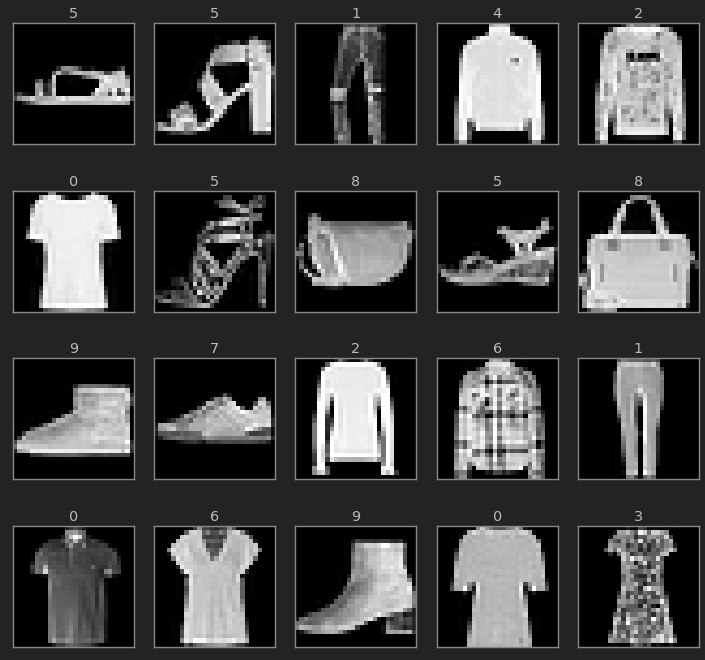

In [62]:
training_batch_size = 64# NUMBER OS SAMPLES BEFORE UPDATE

train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('FashionMNIST', train=True, download=True,\
                                                                 transform=transforms.Compose([transforms.ToTensor(),])),
                                                                batch_size=training_batch_size, shuffle=True)

test_batch_size = 10000

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('FashionMNIST', train=False, download=True,\
                                                                transform=transforms.Compose([transforms.ToTensor(),])), 
                                                                batch_size=test_batch_size, shuffle=True)


dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(10,10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
    fig.tight_layout()

## Feed-forward neural network

Now we define a feed-forward neural network by writing a class **Feed_Forward_Neural_Network** that is a subclass of **torch.nn.Module**. The constructor takes a variable *dimensions* as its arguments, which is an array of dimensions for the parameters of the network's affine-linear transformations. The length of the array implicitly defines the number of layers of the neural network. The activation functions are set to be $\varphi_l(x) = \tanh(x)$ for all layers $l$.

In [63]:
class Feed_Forward_Neural_Network(nn.Module):
    def __init__(self, dimensions):
        super(Feed_Forward_Neural_Network, self).__init__()
        self.affine_transformations = nn.ModuleList([nn.Linear(dimensions[k], dimensions[k + 1]) \
                                                     for k in range(len(dimensions) - 1)])
    
        self.dropout = nn.Dropout(0.1)
        self.activation_function = nn.Tanh()
    
    def forward(self, x):
        for counter in range(len(self.affine_transformations)):
            x = self.activation_function(self.affine_transformations[counter](x))
            x = self.dropout(x) 
        return x

whose structure and operations we can display

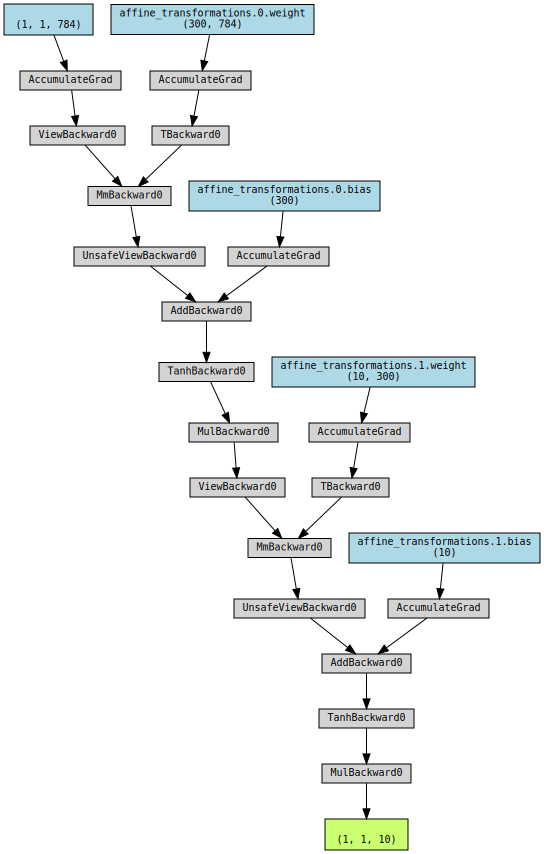

In [64]:
model2 = Feed_Forward_Neural_Network(dimensions)
x = torch.randn(1, 1, 784).requires_grad_(True)
y = model2(x)
make_dot(y, params=dict(list(model2.named_parameters())))#.render("rnn_torchviz_11", format="png")

Furthermore, we define a function **accuracy** that computes the classification accuracy of the outputs *outputs* of a network for given labels *labels*.

In [65]:
def accuracy(outputs, labels):
    prediction = outputs.max(1, keepdim=True)[1].squeeze()
    prediction_comparison = torch.eq(prediction, labels)
    return 100 * (prediction_comparison.sum() / torch.numel(prediction_comparison))

Next, we initialise an instance *neural_network* of the class *Feed_Forward_Neural_Network* for the parameters as depicted above.

In [66]:
dimensions = [784, 300, 10]
neural_network = Feed_Forward_Neural_Network(dimensions).to(device)
neural_network

Feed_Forward_Neural_Network(
  (affine_transformations): ModuleList(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (activation_function): Tanh()
)

Subsequently, we train the network parameters via stochastic gradient descent (with heavy-ball momentum). As described in the exercise, we use the cross entropy loss function. In PyTorch, we specify this criterion *criterion* via the call *nn.CrossEntropyLoss()*. We store a couple of additional parameters and run several epochs. 

In [67]:
criterion = nn.CrossEntropyLoss()
number_of_epochs = 10
step_size = 0.005
momentum_parameter = 0.7
optimiser = optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum_parameter)

running_loss = []
running_test_loss = []
running_training_accuracy = []
running_training_accuracy.append(10)
running_test_accuracy = []
running_test_accuracy.append(10)

for k in range(number_of_epochs):
    
    epoch_loss = 0
    training_accuracy = 0
    
    for j, (images, labels) in enumerate(train_loader):      
        images = images.to(device)
        labels = labels.to(device)
        
        optimiser.zero_grad()        
        outputs = neural_network(images.view(-1, dimensions[0]))
        #outputs = neural_network(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step() 
        
        epoch_loss += loss.item()
        training_accuracy += accuracy(outputs, labels)
        
    running_loss.append(1/len(train_loader) * epoch_loss)    
    running_training_accuracy.append(1/len(train_loader) * training_accuracy.cpu().detach().numpy())
    with torch.no_grad():
        test_images, test_labels = iter(test_loader).next()
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        test_outputs = neural_network(test_images.view(-1, dimensions[0]))
        #test_outputs = neural_network(test_images)
        test_loss = criterion(test_outputs, test_labels)
        running_test_loss.append(test_loss.cpu().detach().numpy())
        test_accuracy = accuracy(test_outputs, test_labels)
        running_test_accuracy.append(test_accuracy.cpu().detach().numpy())
        
    if (k + 1) % 1 == 0:    
        print('Epoch [{:d}/{:d}], Loss: {:.4f}, Accuracy: {:.2f} / {:.2f} '.format(k + 1,\
               number_of_epochs, running_loss[k], running_training_accuracy[k + 1], test_accuracy))

print('Epoch [{:d}/{:d}] completed, Loss: {:.4f}, Training accuracy: {:.2f} / {:.2f}'.format(k + 1,\
        number_of_epochs, running_loss[k], running_training_accuracy[k + 1], test_accuracy))

Epoch [1/10], Loss: 1.4518, Accuracy: 64.56 / 68.71 
Epoch [2/10], Loss: 1.2435, Accuracy: 70.96 / 71.94 
Epoch [3/10], Loss: 1.1933, Accuracy: 73.87 / 73.88 
Epoch [4/10], Loss: 1.1671, Accuracy: 75.69 / 75.26 
Epoch [5/10], Loss: 1.1491, Accuracy: 76.87 / 76.21 
Epoch [6/10], Loss: 1.1379, Accuracy: 77.59 / 76.68 
Epoch [7/10], Loss: 1.1267, Accuracy: 78.22 / 77.88 
Epoch [8/10], Loss: 1.1190, Accuracy: 78.78 / 77.70 
Epoch [9/10], Loss: 1.1129, Accuracy: 79.13 / 78.28 
Epoch [10/10], Loss: 1.1072, Accuracy: 79.44 / 78.24 
Epoch [10/10] completed, Loss: 1.1072, Training accuracy: 79.44 / 78.24


We then store the trained model parameters in the file 'trained_neural_network' for later re-use.

In [68]:
torch.save(neural_network.state_dict(), 'trained_neural_network')

The following plots visualise the loss of the cross entropy over the course of all epochs and the classification accuracy on the training as well as the test dataset.

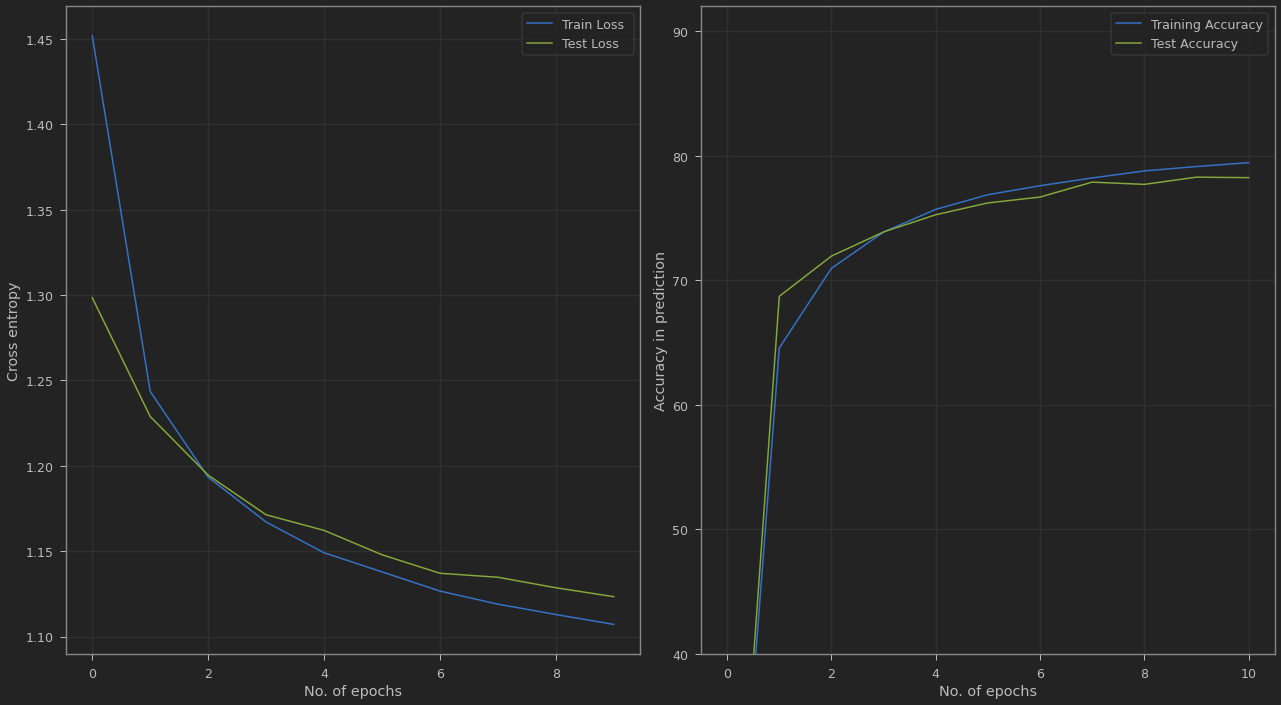

In [69]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.arange(number_of_epochs), running_loss, label='Train Loss ')
ax1.plot(np.arange(number_of_epochs), running_test_loss, label='Test Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Cross entropy')
ax1.legend()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.arange(number_of_epochs + 1), running_training_accuracy, label='Training Accuracy')
ax2.plot(np.arange(number_of_epochs + 1), running_test_accuracy, label='Test Accuracy')
ax2.set_xlabel('No. of epochs')
ax2.set_ylabel('Accuracy in prediction')
ax2.legend()
ax2.set_ylim((40, 92))
plt.tight_layout()

We visually test our trained network on an arbitrary sample of the training dataset.

/tmp/ipykernel_24351/1226766751.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(image, ax=ax1, fraction=0.05)


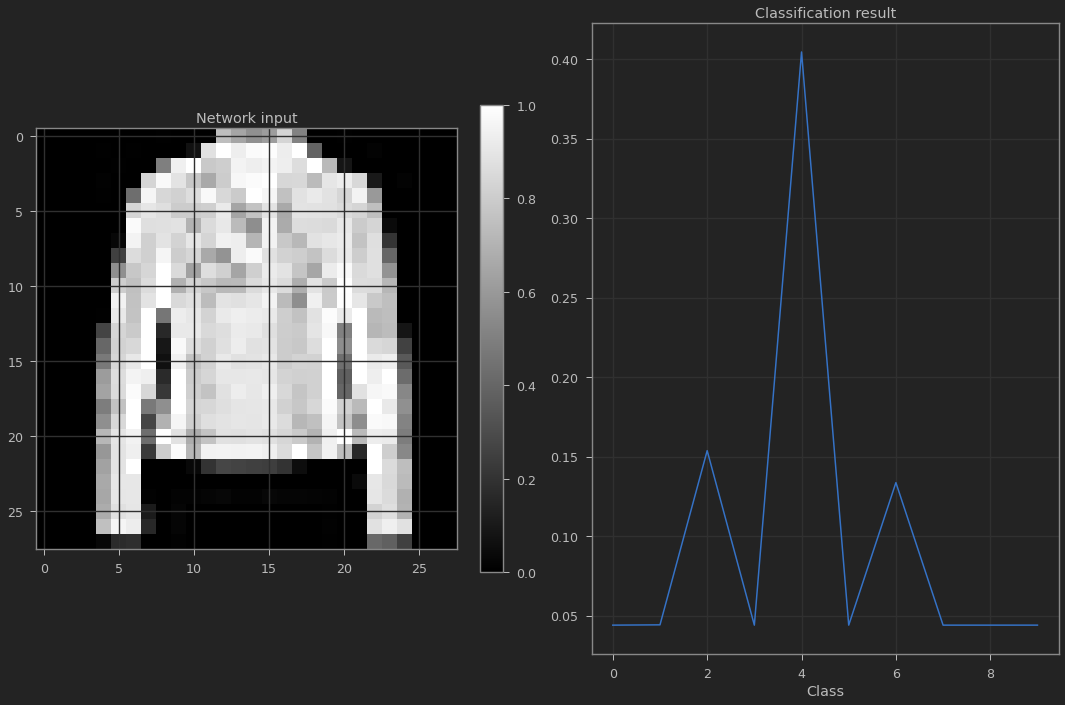

In [46]:
test_images, test_labels = iter(test_loader).next()
test_images = test_images.to(device)
test_labels = test_labels.to(device)
index=torch.randint(high=test_images.shape[0], size=(1,1)).squeeze()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

image = ax1.imshow(test_images[index][0].cpu().detach().numpy(), cmap='gray')
ax1.set_title('Network input')
fig.colorbar(image, ax=ax1, fraction=0.05)
ax2.plot(nn.functional.softmax(neural_network(test_images[index][0].view(-1, 784)).view(-1), dim=0).detach().cpu().numpy())
ax2.set_xlabel('Class')
ax2.set_title('Classification result')
fig.tight_layout()

It is evident that classification be meanss of Feed-Foreward NN is not the optimal approach. Convolutional NNs provides us with much capabilities as far as imagess clasiffication is concerned.